### Understanding computation graphs

PyTorch relies on building a computation graph at its core, and it uses this computation graph to derive relationships between tensors from the input all the way to the output. Let’s say that we have rank 0 (scalar) tensors a, b, and c and we want to evaluate z = 2 × (a – b) + c

In [1]:
import torch
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [2]:
print('Scalar Inputs:', compute_z(torch.tensor(1),torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]),torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]),torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


### Storing and updating model parameters

In [3]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)


tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [4]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)

w.requires_grad_()
print(w.requires_grad)

False
True


initializing model parameters with random weights is necessary to break the symmetry during backpropagation—otherwise, a multilayer NN would be no more useful than a single-layer NN like logistic regression. When creating a PyTorch tensor, we can also use a random initialization scheme.

### Glorot initialization

In [5]:
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [6]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

### Computing the gradients of the loss with respect to trainable variables

In [7]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


### Implementing models based on nn.Sequential

In [8]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

In [9]:
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [10]:
# initializes the weights of the first layer (model[0]) using the Xavier (Glorot) uniform initialization method.
nn.init.xavier_uniform_(model[0].weight)

# This line sets a constant value (0.01) for the L1 regularization weight.
# Also the coefficient to scale the `L1` regularization term.
l1_weight = 0.01

# This line calculates the L1 regularization term for the 3rd layer of the model.
l1_penalty = l1_weight * model[2].weight.abs().sum()

### Choosing a loss function

In [11]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Solving an XOR classification problem

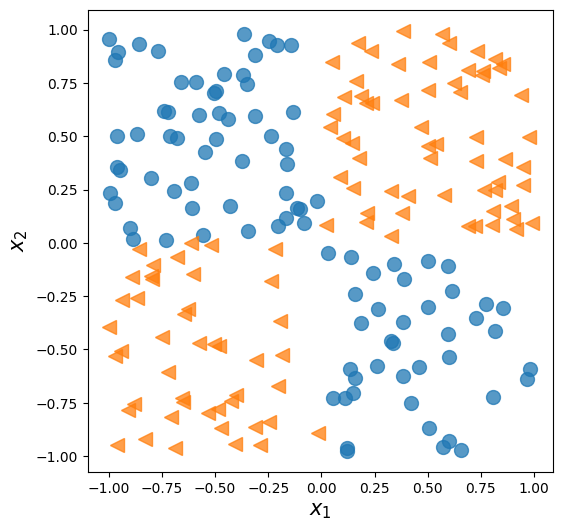

In [12]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [13]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [15]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [16]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, \
           accuracy_hist_train, accuracy_hist_valid
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

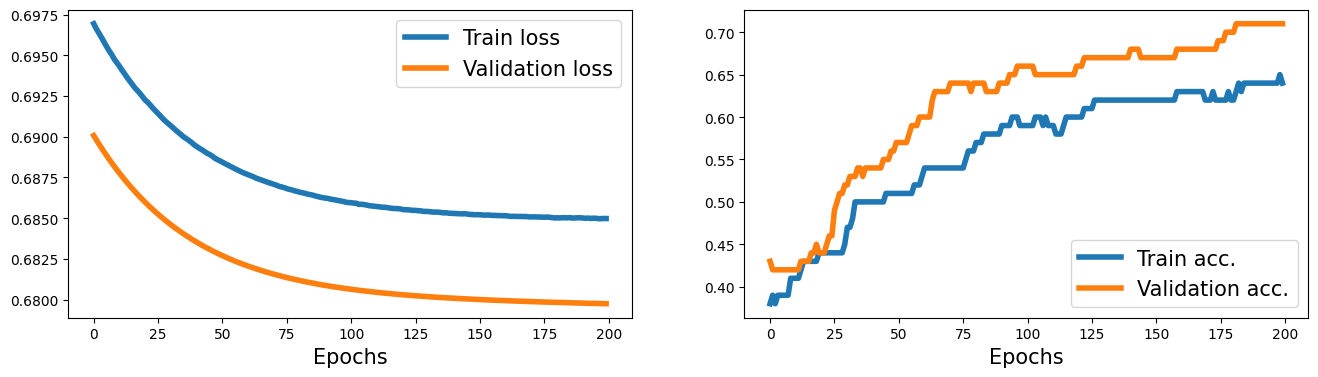

In [17]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

Remark: a simple model with no hidden layer can only derive a linear decision boundary, which is unable to solve the XOR problem. As a consequence, we can observe that the loss terms for both the training and the validation datasets are very high, and the classification accuracy is very low. To derive a nonlinear decision boundary, we can add one or more hidden layers connected via nonlinear activation functions.

In [18]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [19]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

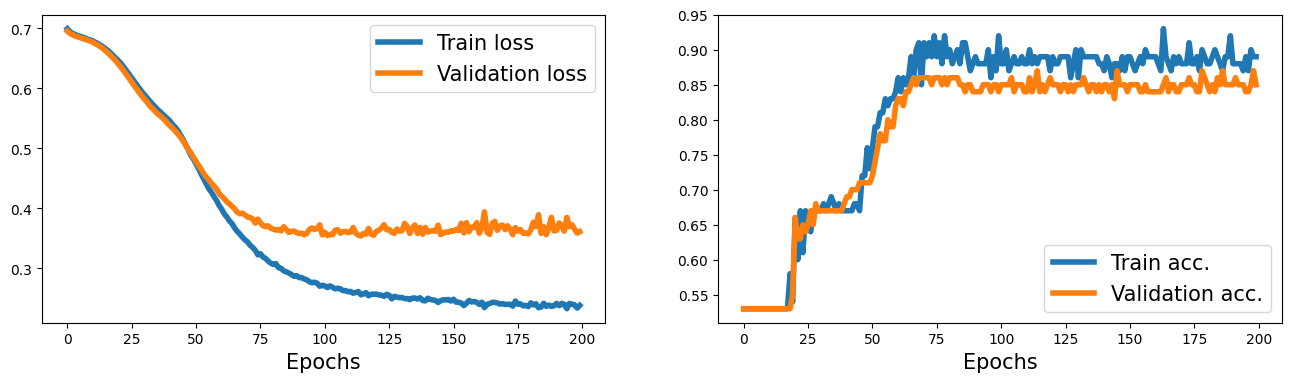

In [20]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

### Making model building more flexible with nn.Module

In [21]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [22]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [23]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

/var/folders/h1/rvjbcw3x19dcwnv6qxb4pxrm0000gn/T/ipykernel_24470/3970076999.py:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y=y_valid.numpy().astype(np.integer),


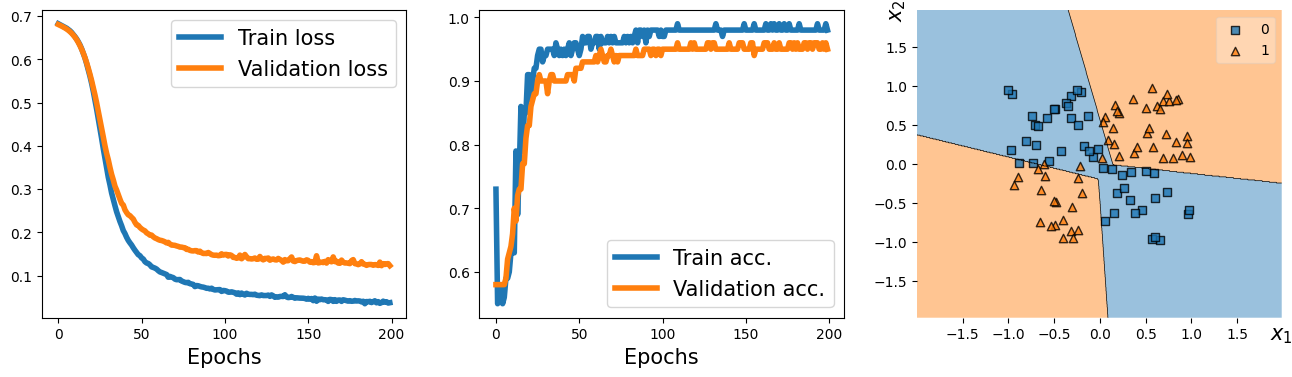

In [24]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(),
                       y=y_valid.numpy().astype(np.integer),
                     clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()